# Random walk hypothesis

In [1]:
import pandas as pd
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import torch.nn as nn
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import EvalCallback

In [ ]:
df = pd.read_csv("data.csv", delimiter="\t")
df["Datetime"] = pd.to_datetime(df["<DATE>"] + " " + df["<TIME>"], format="%Y.%m.%d %H:%M:%S")
df = df.set_index("Datetime")
df = df.rename(columns={
    "<OPEN>": "Open",
    "<HIGH>": "High",
    "<LOW>": "Low",
    "<CLOSE>": "Close"
})
prices = df["Close"]
train_price = prices[:-10**4]
test_price = prices[-10**4:]
print(prices.diff().abs().mean(skipna=True))

0.0008545906459064592


## Defining Environment

In [17]:
class TradingEnv(gym.Env):
    
    def __init__(self, prices, max_steps=np.inf, n=10, penalty=0.00001, scale=1, start_from=0):
        super(TradingEnv, self).__init__()
        
        self.prices = np.array(prices)
        self.n = n
        self.penalty = penalty
        self.scale = scale
        self.max_steps = max_steps
        self.start_from = start_from

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = spaces.Discrete(3)
         
        # Flattened Observation space: (prices, prev_action, action_price)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(n + 2,), dtype=np.float32
        )
        
        self.reset()
    
    def _get_obs(self):
        prices_window = self.prices[self.current_idx - self.n:self.current_idx]
        return np.concatenate([
            prices_window,
            [self.prev_action],
            [self.action_price]
        ]).astype(np.float32)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if self.start_from is None:
            self.current_idx = self.n + self.np_random.integers(0, len(self.prices) - self.n)
        else:
            self.current_idx = self.n + self.start_from
        self.prev_action = 1
        self.action_price = 0
        self.steps = 0
        return self._get_obs(), {}
    
    def step(self, action):
        curr_price = self.prices[self.current_idx - 1]
        terminated = False
        truncated = False
        reward = 0

        # Repeating the same action (buy or sell) is impossible,
        # prev_action and action_price will not be updated.
        # Doing nothing is discouraged as well. 
        if action == self.prev_action or action == 1: 
            reward = -self.penalty
        elif np.abs(self.prev_action - action) == 2: # Closing a position
            reward = (action - 1)* (self.action_price - curr_price) * self.scale
            self.prev_action = 1
            self.action_price = 0
        elif self.prev_action == 1: # Openning a new position
            self.prev_action = action
            self.action_price = curr_price

        
        self.current_idx += 1
        self.steps += 1

        if self.current_idx >= len(self.prices):
            terminated = True
        
        if self.steps >= self.max_steps:
            truncated = True

        obs = self._get_obs()
        return obs, reward, terminated, truncated, {}
    
    
def create_env(train=True, penalty=0.00001, start_from=0, max_steps=np.inf):
    data = train_price if train else test_price
    vec_env = make_vec_env(lambda: TradingEnv(data, penalty=penalty, 
            start_from=start_from, max_steps=max_steps), n_envs=1)
    return VecNormalize(vec_env, norm_obs=True, norm_reward=False)

The following combines different features before feeding it to the PPO.

In [18]:
class TradingFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=64):
        super().__init__(observation_space, features_dim)

        self.n_prices = observation_space.shape[0] - 2 # action is one hotcoded
        self.price_net = nn.Sequential(
            nn.Linear(self.n_prices, 32),
            nn.SELU(),
        )
        self.action_net = nn.Sequential(
            nn.Linear(1, 2),
            nn.SELU()
        )
        self.action_price_net = nn.Sequential(
            nn.Linear(1, 2),  
            nn.SELU(),
        )
        self.final_net = nn.Sequential(
            nn.Linear(36, features_dim),
            nn.SELU(),
        )

    def forward(self, obs):
        prices = obs[:, :self.n_prices]
        prev_action = obs[:, -2:-1]
        prev_price = obs[:, -1:]
        p_out = self.price_net(prices)
        a_out = self.action_net(prev_action)
        ap_out = self.action_price_net(prev_price)
        return self.final_net(th.cat([p_out, a_out, ap_out], dim=-1))

## RandomAgent
We first check the peformance of the RandomAgent that only takes random actions. In a real world scenario, there is no penalty for holding a position, but during the training it is necessary to stop the model from becoming lazy. 

In [105]:
class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def predict(self, observation, state=None, episode_start=None, deterministic=False):
        action = self.action_space.sample()
        return np.array([action]), None


env = create_env(train=False)
print(f"Test - Random: {evaluate_policy(RandomAgent(env.action_space), env, n_eval_episodes=100)}")

env = create_env(train=False, penalty=0)
print(f"Test - Random - No Penality: {evaluate_policy(RandomAgent(env.action_space), env, n_eval_episodes=100)}")

Test - Random: (np.float64(-0.0491881), np.float64(0.09071702770367865))
Test - Random - No Penality: (np.float64(-0.005329), np.float64(0.07567183875788933))


## Training

In [ ]:
eval_freq = 10000
eval_callback = EvalCallback(
    eval_env=create_env(train=False, penalty=0),
    best_model_save_path="./logs/best_model/",
    log_path="./logs/eval_logs/",
    eval_freq=eval_freq,              
    deterministic=True          
)

policy_kwargs = dict(
    features_extractor_class=TradingFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=64),
)

rollouts_per_episode = len(train_price) // 2048  + 1

model = PPO("MlpPolicy", create_env(), policy_kwargs=policy_kwargs, verbose=2, device="cpu")
model.learn(total_timesteps=10**7, callback=eval_callback, log_interval=rollouts_per_episode)
model.save("RLF_v3")

### Last model vs best model
Clearly, the last model is overfit as it produces signficantly less reward compare to the best model.

In [20]:
l = PPO.load("RLF_v3", create_env(penalty=0), device="cpu")
print(f"Last - Training - PPO: {evaluate_policy(l, create_env(penalty=0), n_eval_episodes=1)}")
print(f"Last - Test - PPO: {evaluate_policy(l, create_env(train=False, penalty=0), n_eval_episodes=1)}")

b = PPO.load("logs/best_model/best_model", create_env(penalty=0), device="cpu")
print(f"Best - Training - PPO: {evaluate_policy(b, b.env, n_eval_episodes=1)}")
print(f"Best - Test - PPO: {evaluate_policy(b, create_env(train=False, penalty=0), n_eval_episodes=1)}")

Last - Training - PPO: (np.float64(0.45018), np.float64(0.0))
Last - Test - PPO: (np.float64(0.08183), np.float64(0.0))
Best - Training - PPO: (np.float64(0.20191), np.float64(0.0))
Best - Test - PPO: (np.float64(0.17638), np.float64(0.0))


## Reward Sanity Check

In [69]:
done = False
actions = []
rewards = []
obs_list = []
env = create_env(train=False, penalty=0)
obs = env.reset()
prev_action = np.array([1])

while not done:

    action, _ = b.predict(obs, deterministic=True)

    if action == prev_action or action == 1:
        action = np.array([1])
    elif np.abs(prev_action - action) == 2:
        prev_action = np.array([1])
    elif prev_action == 1:
        prev_action = action 

    obs, reward, done, info = env.step(action)    
    actions.append(action)
    rewards.append(reward)
    obs_list.append(obs)

print(f"rewards were calculated properly by evaluate_policy: {np.sum(rewards)}")

rewards were calculated properly by evaluate_policy: 0.1763800084590912


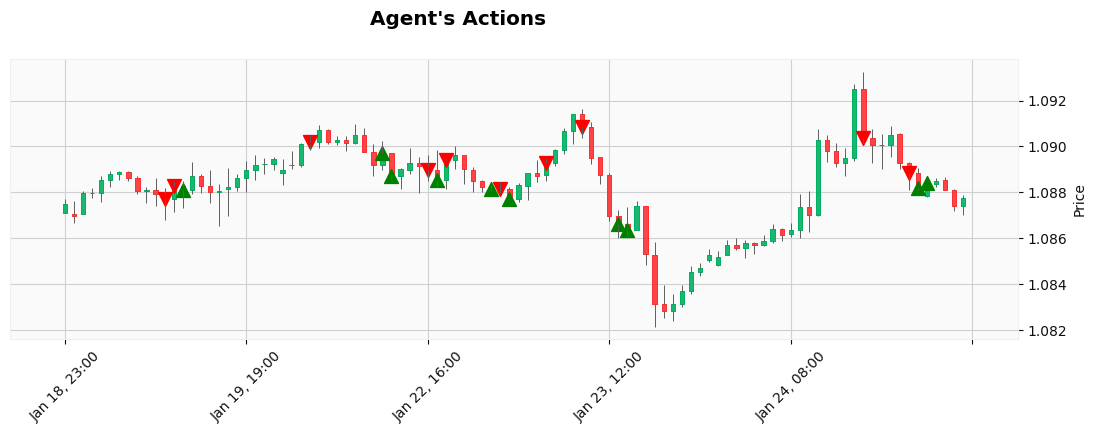

In [68]:
import mplfinance as mpf

tdf = df.tail(10**4 - 10).iloc[100:200]
tac = np.array(actions[100:200]).flatten()


buy_signals = pd.Series(np.where(tac == 2, tdf['Close'], np.nan), index=tdf.index)
sell_signals = pd.Series(np.where(tac == 0, tdf['Close'], np.nan), index=tdf.index)


apds = [
    mpf.make_addplot(buy_signals, type='scatter', markersize=100, marker='^', color='g'),
    mpf.make_addplot(sell_signals, type='scatter', markersize=100, marker='v', color='r')
]

mpf.plot(tdf, type='candle', addplot=apds, style='yahoo', ylabel="Price", title="Agent's Actions", figsize=(14, 4))


### TODO: Train on random data